## 패키지 import

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.image as mpimg

import os
import cv2
import PIL
import shutil
import tensorflow
from PIL import Image 
# import keras
from tensorflow import keras

# from tensorflow.keras.utils import load_img, img_to_array
# from keras.utils import load_img, img_to_array
from keras_preprocessing.image import load_img, img_to_array

# 이미지 데이터 증강
# from tensorflow.keras.preprocessing import image
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
# from keras_preprocessing.image import ImageDataGenerator

# 옵티마이저
# from tensorflow.keras.optimizers import Adam
from keras.optimizers import Adam

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

In [ ]:
# 파일 압축 풀기
# %cd 압축을 풀 경로
# !unzip -qq "압축파일 Path"
%cd /content/drive/MyDrive/6dogma_sy/res
!unzip -qq "/content/drive/MyDrive/6dogma_sy/res/fail_test_train.zip"

/content/drive/MyDrive/6dogma_sy/res


## 이미지 데이터 불러오기

In [ ]:
# 기본 경로
base_dir = '/content/drive/MyDrive/6dogma_sy/res/train_img_all/'
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

# 훈련용 Good/Bad 이미지 경로
train_G_dir = os.path.join(train_dir, 'Good')
train_B_dir = os.path.join(train_dir, 'bad')
print(train_G_dir, train_B_dir)

# 테스트용 Good/Bad 이미지 경로
test_G_dir = os.path.join(test_dir, 'Good')
test_B_dir = os.path.join(test_dir, 'bad')
print(test_G_dir, test_B_dir)

/content/drive/MyDrive/6dogma_sy/res/train_img_all/train/Good /content/drive/MyDrive/6dogma_sy/res/train_img_all/train/bad
/content/drive/MyDrive/6dogma_sy/res/train_img_all/test/Good /content/drive/MyDrive/6dogma_sy/res/train_img_all/test/bad


In [ ]:
# 훈련용 이미지 파일 이름 조회

train_G_fnames = os.listdir(train_G_dir)
train_B_fnames = os.listdir(train_B_dir)
print(train_G_fnames)
print(train_B_fnames)

In [ ]:
# 각 디렉토리에 저장되어 있는 이미지 파일 수 확인

print('Total training G images :', len(os.listdir(train_G_dir)))
print('Total training B images :', len(os.listdir(train_B_dir)))

print('Total test G images :', len(os.listdir(test_G_dir)))
print('Total test B images :', len(os.listdir(test_B_dir)))

Total training G images : 10951
Total training B images : 8204
Total test G images : 711
Total test B images : 604


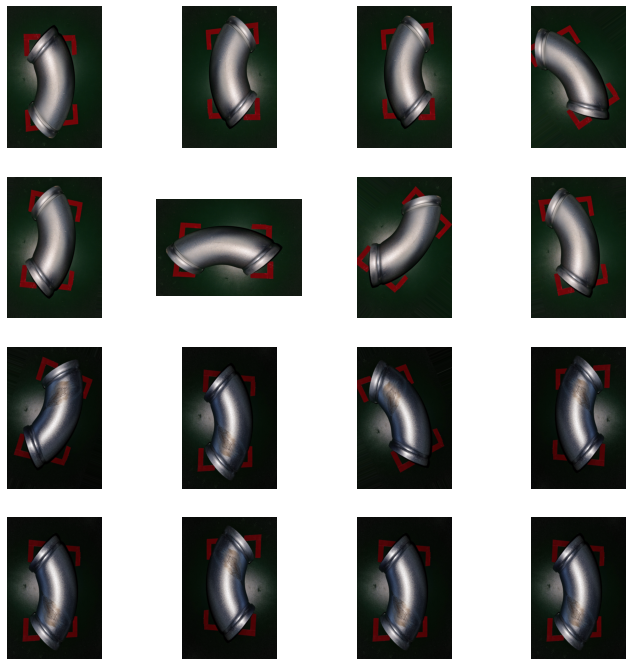

In [ ]:
# 이미지 확인

nrows, ncols = 4, 4
pic_index = 0

fig = plt.gcf()
fig.set_size_inches(ncols*3, nrows*3)

pic_index += 8

next_G_pix = [os.path.join(train_G_dir, fname) for fname in train_G_fnames[pic_index-8:pic_index]]
next_B_pix = [os.path.join(train_B_dir, fname) for fname in train_B_fnames[pic_index-8:pic_index]]

for i, img_path in enumerate(next_G_pix+next_B_pix):
    sp = plt.subplot(nrows, ncols, i+1)
    sp.axis('OFF')
    
    img = mpimg.imread(img_path)
    plt.imshow(img)
    
plt.show()

## 이미지 데이터 생성

In [ ]:
# 이미지 정규화
train_datagen = ImageDataGenerator(rescale = 1./255) # 모든 이미지 원소값들을 255로 나누기

                                  
test_datagen = ImageDataGenerator(rescale = 1./255) 

In [ ]:
# flow_from_directory() 메서드를 이용해서 훈련과 테스트에 사용될 이미지 데이터를 만들기
# 변환된 이미지 데이터 생성
train_generator = train_datagen.flow_from_directory(train_dir, 
                                                    batch_size=1024, # 한번에 변환된 이미지 64개씩 만들어라 라는 것
                                                    color_mode='grayscale', # 흑백 이미지 처리
                                                    class_mode='binary', 
                                                    target_size=(256,256)) # target_size에 맞춰서 이미지의 크기가 조절된다

test_generator = test_datagen.flow_from_directory(test_dir,
                                                  batch_size=64,
                                                  color_mode='grayscale',
                                                  class_mode='binary',
                                                  target_size=(256,256))
# 참고로, generator 생성시 batch_size x steps_per_epoch (model fit에서) <= 훈련 샘플 수 보다 작거나 같아야 한다.

Found 19155 images belonging to 2 classes.
Found 1315 images belonging to 2 classes.


In [ ]:
# class 확인
train_generator.class_indices

{'Good': 0, 'bad': 1}

## 모델링

- 합성곱 신경망 모델 구성
- 출력층의 활성화함수로 'sigmoid' 사용
  - 0과 1 두 가지로 분류되는 'binary' 분류 문제에 적합하기 때문

In [ ]:
# 합성곱 신경망 모델 구성하기 - 최종 모델
import tensorflow as tf

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), padding='same', activation='relu', input_shape=(256, 256, 1)),
    tf.keras.layers.MaxPooling2D(2),
    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(2),
    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(80, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.summary() # 신경망의 구조 확인

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 16)      160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 32)        9248      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 32, 32, 32)       0

## 모델 학습

- 손실 함수로 ‘binary_crossentropy’를 사용
- 옵티마이저로는 Adam을 사용

In [ ]:
# 모델 로드
loaded_model = tensorflow.keras.models.load_model('/content/drive/MyDrive/6dogma_sy/model/cnn_epo6.h5')
print(type(loaded_model))

<class 'keras.engine.sequential.Sequential'>


In [ ]:
# 모델 컴파일 - 최종 모델
# compile() 메서드를 이용해서 손실 함수 (loss function)와 옵티마이저 (optimizer)를 지정
model.compile(optimizer=Adam(learning_rate=0.001), # 옵티마이저로는 Adam 사용
              loss='binary_crossentropy', # 손실 함수로 ‘binary_crossentropy’ 사용
              metrics= ['accuracy'])

In [ ]:
# 모델 훈련 - 재훈련
history = model.fit_generator(train_generator, # train_generator안에 X값, y값 다 있으니 generator만 주면 된다
                              validation_data=test_generator, # validatino_generator안에도 검증용 X,y데이터들이 다 있으니 generator로 주면 됨
                              steps_per_epoch=16, # 한 번의 에포크(epoch)에서 훈련에 사용할 배치(batch)의 개수 지정; generator를 4번 부르겠다
                              epochs=7, # 데이터셋을 한 번 훈련하는 과정; epoch은 100 이상은 줘야한다
                              validation_steps=16, # 한 번의 에포크가 끝날 때, 검증에 사용되는 배치(batch)의 개수를 지정; validation_generator를 4번 불러서 나온 이미지들로 작업을 해라
                              verbose=2)
# 참고: validation_steps는 보통 내가 원하는 이미지 수에 flow할 때 지정한 batchsize로 나눈 값을 validation_steps로 지정

<ipython-input-11-2fea9a0883cd>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator, # train_generator안에 X값, y값 다 있으니 generator만 주면 된다


Epoch 1/7
16/16 - 3101s - loss: 0.5830 - accuracy: 0.6741 - val_loss: 0.3645 - val_accuracy: 0.8623 - 3101s/epoch - 194s/step
Epoch 2/7
16/16 - 556s - loss: 0.2677 - accuracy: 0.8974 - val_loss: 0.1751 - val_accuracy: 0.9434 - 556s/epoch - 35s/step
Epoch 3/7
16/16 - 323s - loss: 0.1165 - accuracy: 0.9572 - val_loss: 0.0533 - val_accuracy: 0.9814 - 323s/epoch - 20s/step
Epoch 4/7
16/16 - 279s - loss: 0.0472 - accuracy: 0.9818 - val_loss: 0.0287 - val_accuracy: 0.9941 - 279s/epoch - 17s/step
Epoch 5/7
16/16 - 275s - loss: 0.0211 - accuracy: 0.9932 - val_loss: 0.0160 - val_accuracy: 0.9980 - 275s/epoch - 17s/step
Epoch 6/7
16/16 - 275s - loss: 0.0103 - accuracy: 0.9979 - val_loss: 0.0059 - val_accuracy: 0.9990 - 275s/epoch - 17s/step
Epoch 7/7
16/16 - 278s - loss: 0.0057 - accuracy: 0.9989 - val_loss: 0.0035 - val_accuracy: 1.0000 - 278s/epoch - 17s/step


## 모델 평가

In [ ]:
# 모델 로드
loaded_model = tensorflow.keras.models.load_model('/content/drive/MyDrive/6dogma_sy/model/cnn_padding.h5')
print(type(loaded_model))

<class 'keras.engine.sequential.Sequential'>


In [ ]:
# 모델 성능 평가 (훈련 데이터)
model.evaluate(train_generator)

19/19 [==============================] - 312s 16s/step - loss: 0.0020 - accuracy: 0.9996


[0.0019782877061516047, 0.9996345639228821]

In [ ]:
# 모델 성능 평가 (검증 데이터)
model.evaluate(test_generator)

21/21 [==============================] - 21s 971ms/step - loss: 0.0066 - accuracy: 0.9992


[0.00661142822355032, 0.9992395639419556]

1/1 [==============================] - 0s 17ms/step


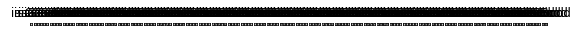

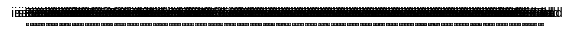

In [ ]:
# 테스트 평가 - 160개씩 테스트

from keras.preprocessing import image

# 테스트용 Good 이미지 경로 설정
test_dir = '/content/drive/MyDrive/6dogma_sy/res/test_RGBA3/'
test_G_dir = os.path.join(test_dir, 'Good/')
test_G_filenames = os.listdir(test_G_dir)
test_G_filenames

# 테스트용 Bad 이미지 경로 설정
test_dir = '/content/drive/MyDrive/6dogma_sy/res/test_RGBA3/'
test_B_dir = os.path.join(test_dir, 'bad/')
test_B_filenames = os.listdir(test_B_dir)
test_B_filenames

# Good,bad를 key로, 이미지 파일 이름들을 value로 dictionary 생성
dic_GB_filenames = {}
dic_GB_filenames['Good'] = test_G_filenames
dic_GB_filenames['bad'] = test_B_filenames


G_list = []
B_list = []
# Good/Bad 분류 테스트
for GB, filenames in dic_GB_filenames.items():
    fig = plt.figure(figsize=(16,10))
    rows, cols = 2, 276



    for i, fn in enumerate(filenames):
        path = test_dir + GB + '/' + fn
        test_img = keras.utils.load_img(path, color_mode='grayscale', target_size=(256, 256), interpolation='bilinear')        
        x = keras.utils.img_to_array(test_img)
        x = np.expand_dims(x, axis=0)
        images = np.vstack([x])

        classes = loaded_model.predict(images, batch_size=16)
        

        fig.add_subplot(rows, cols, i+1)
        if classes[0]==0:
            # plt.title(fn + " is Good")
            plt.title(" is Good")
            plt.axis('off')
            plt.imshow(test_img, cmap='gray')
            tmp = classes.tolist()


        else:
            plt.title(" is Bad")
            plt.axis('off')
            plt.imshow(test_img, cmap='gray')
            tmp = classes.tolist()
            
        
        if GB == 'Good':
          G_list.append(tmp[0][0])
        else:
          B_list.append(tmp[0][0])

    # plt.show()
    # print(G_list)
    # print(B_list)

In [ ]:
# 증강 이상한 데이터(회전 시 주변 채우는게 이상함)
print(f'양품 판별률 : {G_list.count(0)}/{len(G_list)} = {(G_list.count(0)/len(G_list))*100:.2f}%')
print(f'불량 판별률 : {B_list.count(1)}/{len(B_list)} = {(B_list.count(1)/len(B_list))*100:.2f}%')
print(f'전체 정확도 : {G_list.count(0)+B_list.count(1)}/{len(G_list)+len(B_list)} = {(G_list.count(0)+B_list.count(1))/(len(G_list)+len(B_list))*100:.2f}%')
print(f'전체 오차율 : {G_list.count(1)+B_list.count(0)}/{len(G_list)+len(B_list)} = {(G_list.count(1)+B_list.count(0))/(len(G_list)+len(B_list))*100:.2f}%')

양품 판별률 : 120/160 = 75.00%
불량 판별률 : 74/160 = 46.25%
전체 정확도 : 194/320 = 60.62%
전체 오차율 : 100/320 = 31.25%


In [ ]:
# cnn_epo6 모델 테스트
print(f'양품 판별률 : {G_list.count(0)}/{len(G_list)} = {(G_list.count(0)/len(G_list))*100:.2f}%')
print(f'불량 판별률 : {B_list.count(1)}/{len(B_list)} = {(B_list.count(1)/len(B_list))*100:.2f}%')
print(f'전체 정확도 : {G_list.count(0)+B_list.count(1)}/{len(G_list)+len(B_list)} = {(G_list.count(0)+B_list.count(1))/(len(G_list)+len(B_list))*100:.2f}%')
print(f'전체 오차율 : {G_list.count(1)+B_list.count(0)}/{len(G_list)+len(B_list)} = {(G_list.count(1)+B_list.count(0))/(len(G_list)+len(B_list))*100:.2f}%')

양품 판별률 : 133/176 = 75.57%
불량 판별률 : 153/176 = 86.93%
전체 정확도 : 286/352 = 81.25%
전체 오차율 : 36/352 = 10.23%


In [ ]:
# 2만장 재학습 모델 테스트 epoch10
print(f'양품 판별률 : {G_list.count(0)}/{len(G_list)} = {(G_list.count(0)/len(G_list))*100:.2f}%')
print(f'불량 판별률 : {B_list.count(1)}/{len(B_list)} = {(B_list.count(1)/len(B_list))*100:.2f}%')
print(f'전체 정확도 : {G_list.count(0)+B_list.count(1)}/{len(G_list)+len(B_list)} = {(G_list.count(0)+B_list.count(1))/(len(G_list)+len(B_list))*100:.2f}%')
print(f'전체 오차율 : {G_list.count(1)+B_list.count(0)}/{len(G_list)+len(B_list)} = {(G_list.count(1)+B_list.count(0))/(len(G_list)+len(B_list))*100:.2f}%')

양품 판별률 : 84/176 = 47.73%
불량 판별률 : 175/176 = 99.43%
전체 정확도 : 259/352 = 73.58%
전체 오차율 : 73/352 = 20.74%


In [ ]:
# 2만장 재학습 모델 테스트 epoch7
print(f'양품 판별률 : {G_list.count(0)}/{len(G_list)} = {(G_list.count(0)/len(G_list))*100:.2f}%')
print(f'불량 판별률 : {B_list.count(1)}/{len(B_list)} = {(B_list.count(1)/len(B_list))*100:.2f}%')
print(f'전체 정확도 : {G_list.count(0)+B_list.count(1)}/{len(G_list)+len(B_list)} = {(G_list.count(0)+B_list.count(1))/(len(G_list)+len(B_list))*100:.2f}%')
print(f'전체 오차율 : {G_list.count(1)+B_list.count(0)}/{len(G_list)+len(B_list)} = {(G_list.count(1)+B_list.count(0))/(len(G_list)+len(B_list))*100:.2f}%')

양품 판별률 : 111/176 = 63.07%
불량 판별률 : 164/176 = 93.18%
전체 정확도 : 275/352 = 78.12%
전체 오차율 : 60/352 = 17.05%


In [ ]:
# epoch7에 테스트 데이터 학습시키고, 같은 테스트 데이터로 테스트
print(f'양품 판별률 : {G_list.count(0)}/{len(G_list)} = {(G_list.count(0)/len(G_list))*100:.2f}%')
print(f'불량 판별률 : {B_list.count(1)}/{len(B_list)} = {(B_list.count(1)/len(B_list))*100:.2f}%')
print(f'전체 정확도 : {G_list.count(0)+B_list.count(1)}/{len(G_list)+len(B_list)} = {(G_list.count(0)+B_list.count(1))/(len(G_list)+len(B_list))*100:.2f}%')
print(f'전체 오차율 : {G_list.count(1)+B_list.count(0)}/{len(G_list)+len(B_list)} = {(G_list.count(1)+B_list.count(0))/(len(G_list)+len(B_list))*100:.2f}%')

양품 판별률 : 170/176 = 96.59%
불량 판별률 : 163/176 = 92.61%
전체 정확도 : 333/352 = 94.60%
전체 오차율 : 16/352 = 4.55%


In [ ]:
# cnn_epo6모델에 2만장 batch_size 조정해서 훈련한 모델 테스트
print(f'양품 판별률 : {G_list.count(0)}/{len(G_list)} = {(G_list.count(0)/len(G_list))*100:.2f}%')
print(f'불량 판별률 : {B_list.count(1)}/{len(B_list)} = {(B_list.count(1)/len(B_list))*100:.2f}%')
print(f'전체 정확도 : {G_list.count(0)+B_list.count(1)}/{len(G_list)+len(B_list)} = {(G_list.count(0)+B_list.count(1))/(len(G_list)+len(B_list))*100:.2f}%')
print(f'전체 오차율 : {G_list.count(1)+B_list.count(0)}/{len(G_list)+len(B_list)} = {(G_list.count(1)+B_list.count(0))/(len(G_list)+len(B_list))*100:.2f}%')

양품 판별률 : 152/336 = 45.24%
불량 판별률 : 335/336 = 99.70%
전체 정확도 : 487/672 = 72.47%
전체 오차율 : 170/672 = 25.30%


In [ ]:
# padding 추가한 새로운 신경망 모델 테스트
print(f'양품 판별률 : {G_list.count(0)}/{len(G_list)} = {(G_list.count(0)/len(G_list))*100:.2f}%')
print(f'불량 판별률 : {B_list.count(1)}/{len(B_list)} = {(B_list.count(1)/len(B_list))*100:.2f}%')
print(f'전체 정확도 : {G_list.count(0)+B_list.count(1)}/{len(G_list)+len(B_list)} = {(G_list.count(0)+B_list.count(1))/(len(G_list)+len(B_list))*100:.2f}%')
print(f'전체 오차율 : {G_list.count(1)+B_list.count(0)}/{len(G_list)+len(B_list)} = {(G_list.count(1)+B_list.count(0))/(len(G_list)+len(B_list))*100:.2f}%')

양품 판별률 : 335/336 = 99.70%
불량 판별률 : 330/336 = 98.21%
전체 정확도 : 665/672 = 98.96%
전체 오차율 : 6/672 = 0.89%


In [ ]:
# padding 추가한 새로운 신경망 모델 재테스트 - 최종 결과에 씀
print(f'양품 판별률 : {G_list.count(0)}/{len(G_list)} = {(G_list.count(0)/len(G_list))*100:.2f}%')
print(f'불량 판별률 : {B_list.count(1)}/{len(B_list)} = {(B_list.count(1)/len(B_list))*100:.2f}%')
print(f'전체 정확도 : {G_list.count(0)+B_list.count(1)}/{len(G_list)+len(B_list)} = {(G_list.count(0)+B_list.count(1))/(len(G_list)+len(B_list))*100:.2f}%')
print(f'전체 오차율 : {G_list.count(1)+B_list.count(0)}/{len(G_list)+len(B_list)} = {(G_list.count(1)+B_list.count(0))/(len(G_list)+len(B_list))*100:.2f}%')

양품 판별률 : 160/160 = 100.00%
불량 판별률 : 158/160 = 98.75%
전체 정확도 : 318/320 = 99.38%
전체 오차율 : 1/320 = 0.31%


In [ ]:
# padding 추가한 새로운 신경망 모델 얼룩 있는 불량 이미지로 재테스트 - 안씀
print(f'양품 판별률 : {G_list.count(0)}/{len(G_list)} = {(G_list.count(0)/len(G_list))*100:.2f}%')
print(f'불량 판별률 : {B_list.count(1)}/{len(B_list)} = {(B_list.count(1)/len(B_list))*100:.2f}%')
print(f'전체 정확도 : {G_list.count(0)+B_list.count(1)}/{len(G_list)+len(B_list)} = {(G_list.count(0)+B_list.count(1))/(len(G_list)+len(B_list))*100:.2f}%')
print(f'전체 오차율 : {G_list.count(1)+B_list.count(0)}/{len(G_list)+len(B_list)} = {(G_list.count(1)+B_list.count(0))/(len(G_list)+len(B_list))*100:.2f}%')

양품 판별률 : 160/160 = 100.00%
불량 판별률 : 137/160 = 85.62%
전체 정확도 : 297/320 = 92.81%
전체 오차율 : 22/320 = 6.88%


In [ ]:
# 모델 저장
model.save('cnn_padding.h5')